In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# basic_nodes
import numpy as np

class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
    
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
    
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
    
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x

class square_node:
    def __init__(self):
        self._x = None
        self._z = None
    
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z

    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
    
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x)
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx

# dataset_generator

In [3]:
class dataset_generator:
    def __init__(self, feature_dim, n_sample = 300, noise_factor = 0., direction = 1):
        self._feature_dim = feature_dim
        self._n_sample = n_sample
        self._noise_factor = noise_factor
        self._direction = direction
    
        self._init_feature_dict()
        self._init_t_th()
    def _init_feature_dict(self):
        self._feature_dict = dict()
        for feature_idx in range(1, self._feature_dim + 1):
            x_dict = {'mean':0, 'std':1}
            self._feature_dict[feature_idx] = x_dict
        
    def _init_t_th(self):
        self._t_th = [0] + [1 for i in range(self._feature_dim)]
        
    def set_feature_dict(self, feature_dict):
        if len(feature_dict) != self._feature_dim:
            class FeatureDictError(Exception):
                pass
            raise FeatureDictError('The length of "feature_dict" should be equal to "feature_dim"')
        else:
            self._feature_dict = feature_dict
    def set_t_th(self, t_th_list):
        if len(t_th_list) != len(self._t_th):
            class t_th_Error(Exception):
                pass
            raise t_th_Error('The length of "t_th_list" should be equal to "t_th_list"')
        else:
            self._t_th = t_th_list

    def make_dataset(self):
        x_data = np.zeros(shape = (self._n_sample, 1))
        y = np.zeros(shape = (self._n_sample, 1))
        
        for feature_idx in range(1, self._feature_dim + 1):
            feature_dict = self._feature_dict[feature_idx]
            data = np.random.normal(loc = feature_dict['mean'], scale = feature_dict['std'],
                                    size = (self._n_sample, 1))
            x_data = np.hstack((x_data, data))
            y += self._t_th[feature_idx]*data
        y += self._t_th[0]
        y_noise = y + self._noise_factor*np.random.normal(0, 1, (self._n_sample, 1))
        
        if self._direction > 0:
            y_data = (y_noise > 0).astype(np.int)
        else:
            y_data = (y_noise < 0).astype(np.int)
        
        data = np.hstack((x_data, y_data))
        return data

In [4]:
def get_data_batch(data, batch_idx):
    if batch_idx is n_batch -1:
        batch = data[batch_idx*batch_size:]
    else:
        batch = data[batch_idx*batch_size : (batch_idx + 1)* batch_size]
    return batch

# Affine_Function

In [9]:
class Affine_Function:
    def __init__(self):
        self._feature_dim = feature_dim
        
        self._Z1_list = [None]*(self._feature_dim + 1)
        self._Z2_list = self._Z1_list.copy()
        
        self._dZ1_list, self._dZ2_list = self._Z1_list.copy(), self._Z1_list.copy()
        self._dTh_list = self._Z1_list.copy()
        
        self.node_imp()
        self.random_initialization()
        
    def node_imp(self):
        self._node1 = [None] + [mul_node() for _ in range(self._feature_dim)]
        self._node2 = [None] + [plus_node() for _ in range(self._feature_dim)]

    def random_initialization(self):
        r_feature_dim = 1/np.power(self._feature_dim, 0.5)
        self._Th = np.random.uniform(low = -1*r_feature_dim,
                                     high = r_feature_dim,
                                     size = (self._feature_dim + 1,1))
        
    def forward(self, X):
        for node_idx in range(1, self._feature_dim + 1):
            self._Z1_list[node_idx] = self._node1[node_idx].forward(self._Th[node_idx],
                                                                    X[:,node_idx])
        self._Z2_list[1] = self._node2[1].forward(self._Th[0], self._Z1_list[1])
        for node_idx in range(2, self._feature_dim + 1):
            self._Z2_list[node_idx] = self._node2[node_idx].forward(self._Z2_list[node_idx-1],
                                                                    self._Z1_list[node_idx])
        return self._Z2_list[-1]
    
    def backward(self, dZ2_last, lr):
        self._dZ2_list[-1] = dZ2_last
        
        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dZ2, dZ1 = self._node2[node_idx].backward(self._dZ2_list[node_idx])
            self._dZ2_list[node_idx-1] = dZ2
            self._dZ1_list[node_idx] = dZ1
        
        self._dTh_list[0] = self._dZ2_list[0]
        
        for node_idx in reversed(range(1, self._feature_dim + 1)):
            dTh, _ = self._node1[node_idx].backward(self._dZ1_list[node_idx])
            self._dTh_list[node_idx] = dTh
        for th_idx in range(self._Th.shape[0]):
            self._Th[th_idx] = self._Th[th_idx] - lr*np.sum(self._dTh_list[th_idx])

        return self._Th
    
    def get_Th(self):
        return self._Th

# Sigmoid

In [6]:
class Sigmoid:
    def __init__(self):
        self._Pred = None

    def forward(self, Z):
        self._Pred = 1/(1 + np.exp(-1*Z))
        return self._Pred
    
    def backward(self, dPred):
        partial = self._Pred * (1 - self._Pred)
        dZ = dPred * partial
    return dZ

# BinaryCrossEntropy_Loss

In [10]:
class BinaryCrossEntropy_Loss:
    def __init__(self):
        self._Y, self._Pred = None, None
        self._mean_node = mean_node()

    def forward(self, Y, Pred):
        self._Y, self._Pred = Y, Pred
        Loss = -1 * (Y * np.log(self._Pred) + (1 - Y)*np.log(1 - Pred))
        J = self._mean_node.forward(Loss)
        return J

    def backward(self):
        dLoss = self._mean_node.backward(1)
        dPred = dLoss*(self._Pred - self._Y)/(self._Pred * (1 - self._Pred))
        return dPred

# MVLoR Model

In [11]:
class MVLoR:
    def __init__(self):
        self._feature_dim = feature_dim
        self._affine = Affine_Function()
        self._sigmoid = Sigmoid()

    def forward(self, X):
        Z = self._affine.forward(X)
        Pred = self._sigmoid.forward(Z)
        return Pred

    def backward(self, dPred, lr):
        dZ = self._sigmoid.backward(dPred)
        self._affine.backward(dZ,lr)
    
    def get_Th(self):
        return self._affine.get_Th()

# Visualization

In [12]:
def result_visualizer():
    global th_accum, loss_list
    
    fig, ax = plt.subplots(figsize = (30, 10))
    fig.subplots_adjust(hspace = 0.3)
    ax.set_title(r'$\vec{\theta}$' + ' Update')
    
    for feature_idx in range(feature_dim + 1):
        
        ax.plot(th_accum[feature_idx, :], label = r'$\theta_{%d}$'%feature_idx)
        
    ax.legend(loc = 'center left',
              bbox_to_anchor = (1,0.5))
    
    iter_ticks = np.linspace(0, th_accum.shape[1],10).astype(np.int)
    ax.set_xticks(iter_ticks)
    
def result_tracker():
    global iter_idx, check_freq
    global th_accum, affine
    
    if iter_idx % check_freq == 0:
        th_accum = np.hstack((th_accum, model.get_Th()))
        cost_list.append(1)
    iter_idx += 1

#  Dataset Preparation



In [13]:
feature_dim = 4
noise_factor = 0.
direction  = 1
n_sample = 500

data_gen = dataset_generator(feature_dim = feature_dim,
                             n_sample = n_sample,
                             noise_factor = noise_factor,
                             direction = direction)
data = data_gen.make_dataset()

batch_size = 8
n_batch = np.ceil(data.shape[0]/batch_size).astype(int)

In [16]:
model = MVLoR()
BCE_cost = BinaryCrossEntropy_Loss()

th_accum = model.get_Th()
cost_list = []

epochs, lr = 100, 0.05
iter_idx, check_freq = 0, 10

# Training

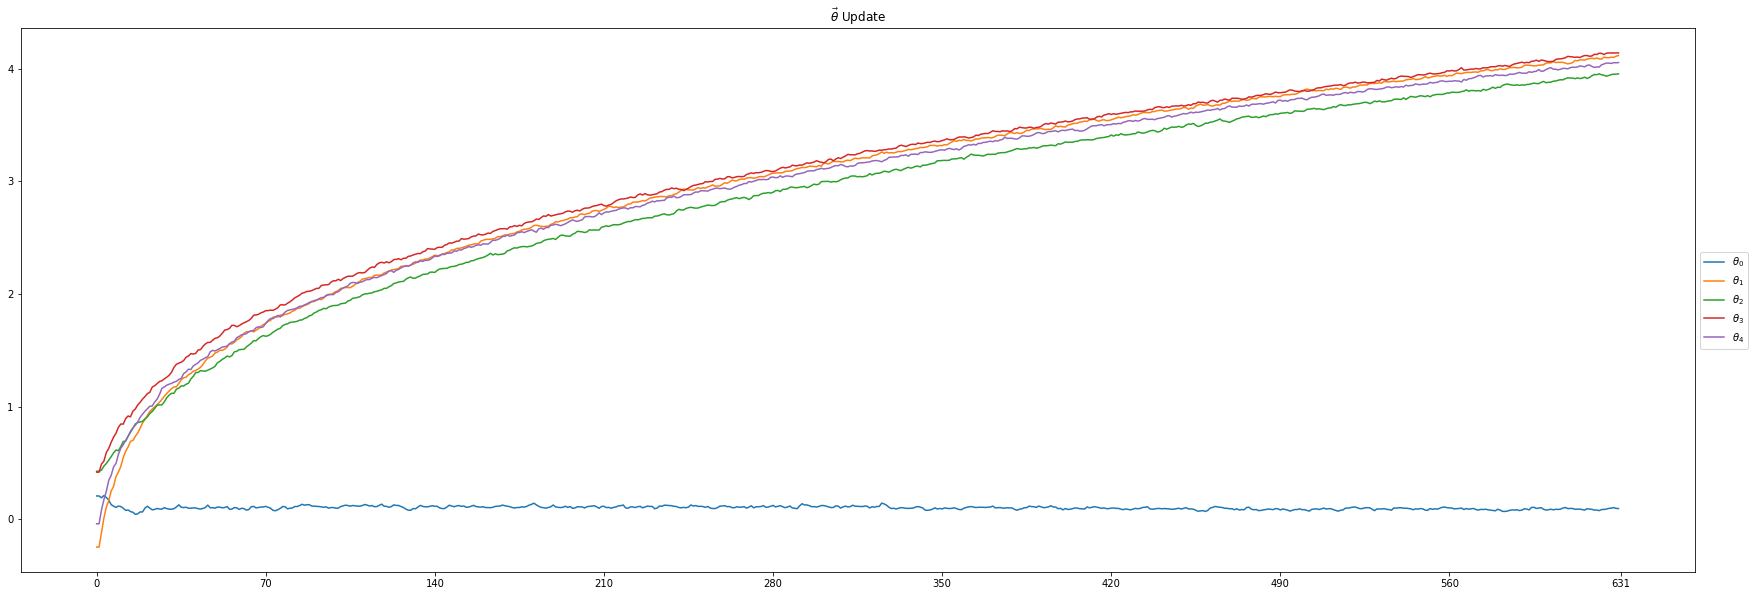

In [15]:
for epoch in range(epochs):
    np.random.shuffle(data)

    for batch_idx in range(n_batch):
        batch = get_data_batch(data, batch_idx)
        X, Y = batch[:,:-1],batch[:,-1]
        
        Pred = model.forward(X)
        J = BCE_cost.forward(Y,Pred)
        
        dPred = BCE_cost.backward()
        model.backward(dPred, lr)

        result_tracker()
        
result_visualizer()